# Seção 05 - Transfer Learning e Fine Tuning
### Aluno: Vinícius Trainotti

# Reconhecer gatos e cachorros

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# plota os gráficos inline e salva no notebook
%matplotlib inline

In [2]:
!wget http://www.razer.net.br/datasets/cats_and_dogs_filtered.zip

--2023-04-01 14:17:57--  http://www.razer.net.br/datasets/cats_and_dogs_filtered.zip
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  66.3MB/s    in 1.0s    

2023-04-01 14:17:58 (66.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# descompactar a base
dataset_path = "./cats_and_dogs_filtered.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [4]:
dataset_path_new = "./cats_and_dogs_filtered"
train_dir = os.path.join(dataset_path_new, "train")
test_dir = os.path.join(dataset_path_new, "validation")

In [5]:
input_shape = (128, 128, 3) # tamanho da imagem entrada
base_model = tf.keras.applications.MobileNetV2(
input_shape=input_shape,
include_top=False,
weights="imagenet")
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [6]:
# Congelar modelo base
base_model.trainable = False

In [8]:
# Adicionar cabeçalho personalizado
print(base_model.output.shape)
# reduzir a dimensionalidade (4 x 4 x 1280 = 20480 pesos para treinar!!)
# Global Average Pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
print(global_average_layer.shape)
prediction_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")(
global_average_layer)

(None, 4, 4, 1280)
(None, 1280)


In [9]:
# Definição do modelo (unir o base com o personalizado)
model = tf.keras.models.Model(base_model.input,
prediction_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [10]:
# compilar o modelo
# testar com o Adam também
model.compile(optimizer=tf.keras.optimizers.RMSprop(
learning_rate=0.0001),
loss="binary_crossentropy",
metrics = ["accuracy"])

In [11]:
# carga das imagens
# Pré-processamento /255
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)
train_generator = data_gen_train.flow_from_directory(
train_dir,
target_size = (128,128),
batch_size = 128,
class_mode = "binary")
test_generator = data_gen_train.flow_from_directory(
test_dir,
target_size = (128,128),
batch_size = 128,
class_mode = "binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
# Treinar o modelo
EPOCHS = 5
r = model.fit(train_generator,
epochs = EPOCHS,
validation_data = test_generator)

Epoch 1/5
16/16 [==============================] - 90s 6s/step - loss: 0.7025 - accuracy: 0.5575 - val_loss: 0.6149 - val_accuracy: 0.6680
Epoch 2/5
16/16 [==============================] - 56s 4s/step - loss: 0.5917 - accuracy: 0.6780 - val_loss: 0.5328 - val_accuracy: 0.7500
Epoch 3/5
16/16 [==============================] - 54s 3s/step - loss: 0.5150 - accuracy: 0.7475 - val_loss: 0.4665 - val_accuracy: 0.8150
Epoch 4/5
16/16 [==============================] - 53s 3s/step - loss: 0.4501 - accuracy: 0.8165 - val_loss: 0.4100 - val_accuracy: 0.8520
Epoch 5/5
16/16 [==============================] - 54s 3s/step - loss: 0.3953 - accuracy: 0.8595 - val_loss: 0.3621 - val_accuracy: 0.8790


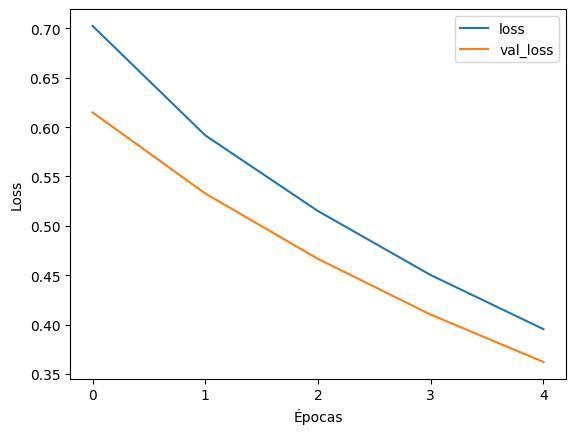

In [13]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

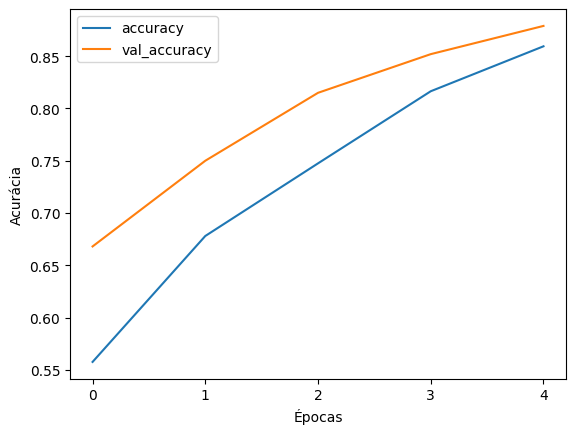

In [14]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

In [15]:
# Avaliação do Modelo
val_loss, val_accuracy = model.evaluate (test_generator)
print(val_accuracy)

8/8 [==============================] - 19s 2s/step - loss: 0.3621 - accuracy: 0.8790
0.8790000081062317


In [16]:
# Efetuar o Fine Tuning
# Primeiro fazer o Transfer Learning
# Depois o Fine Tuning
# descongelar algumas camadas
base_model.trainable = True
len(base_model.layers)
# deixar o início da base
# congelar o final
fine_tuning_at = 100
for l in base_model.layers[:fine_tuning_at]:
  l.trainable = False

In [17]:
#compilar o modelo
# testar com o Adam tb
model.compile(optimizer = tf.keras.optimizers.RMSprop(
learning_rate=0.0001),
loss = "binary_crossentropy",
metrics = ["accuracy"])
# Treinar o modelo
EPOCHS = 5
r = model.fit(train_generator,
epochs = EPOCHS,
validation_data = test_generator)

Epoch 1/5
16/16 [==============================] - 89s 5s/step - loss: 0.2046 - accuracy: 0.9190 - val_loss: 0.0893 - val_accuracy: 0.9670
Epoch 2/5
16/16 [==============================] - 78s 5s/step - loss: 0.0281 - accuracy: 0.9985 - val_loss: 0.0847 - val_accuracy: 0.9690
Epoch 3/5
16/16 [==============================] - 73s 5s/step - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.0951 - val_accuracy: 0.9680
Epoch 4/5
16/16 [==============================] - 74s 5s/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 0.1087 - val_accuracy: 0.9670
Epoch 5/5
16/16 [==============================] - 79s 5s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.1239 - val_accuracy: 0.9630


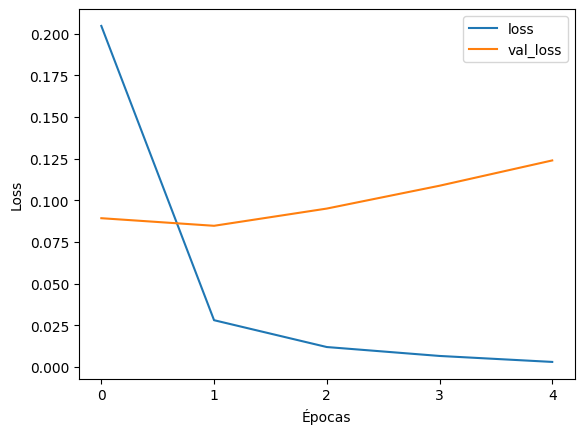

In [18]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

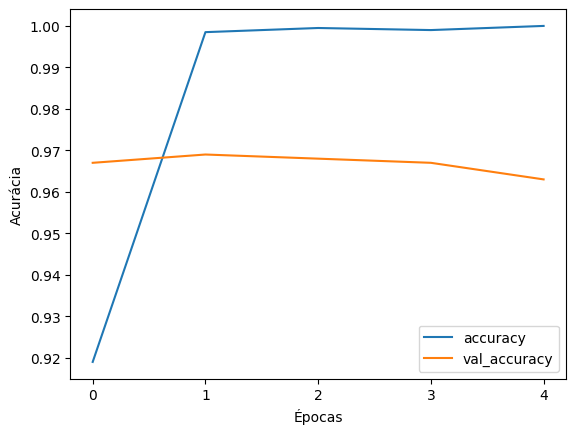

In [19]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

In [20]:
# Avaliação do Modelo
val_loss, val_accuracy = model.evaluate(test_generator)
print(val_accuracy)

8/8 [==============================] - 18s 2s/step - loss: 0.1239 - accuracy: 0.9630
0.9629999995231628
